In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import sweetviz as sv
import statsmodels.api as sm
import pickle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import operator
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from datetime import datetime, timedelta
import itertools

In [3]:
def evaluateArimaModel(data, arima_order):
    """
    Evaluate the performance of an ARIMA model on a given dataset.

    Parameters:
    -----------
    data : pandas Series
        The time series data to fit the ARIMA model on and evaluate its performance.
    arima_order : tuple
        The (p, d, q) order of the ARIMA model.

    Returns:
    --------
    rmse : float
        The root mean squared error (RMSE) of the model's predictions.
    """

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[0:train_size], data[train_size:]

    # Fit the ARIMA model
    model = sm.tsa.ARIMA(train_data, order=arima_order)
    model_fit = model.fit()

    # Make predictions on the test data
    predictions = model_fit.forecast(steps=len(test_data))

    # Calculate the RMSE of the predictions
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    print("MAPE: ")
    print(mape)

    print("RMSE: ")
    print(rmse)

    return rmse


In [4]:
def univariate_sarima(train_data, test_data, order, seasonal_order):
    """
    Fits a univariate SARIMA model to the training data and forecasts the test data.

    Parameters:
    train_data (pd.DataFrame): The training data used to fit the model.
    test_data (pd.DataFrame): The test data used to evaluate the model.
    order (tuple): The (p,d,q) order of the ARIMA model.
    seasonal_order (tuple): The (P,D,Q,s) order of the seasonal ARIMA model.

    Returns:
    fitted_model
    """
    # Fit SARIMA model
    model = SARIMAX(train_data["Number of Crimes"], order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fitted_model = model.fit()

    # Forecast
    y_pred_test = fitted_model.forecast(steps=len(test_data))
    y_pred_train = fitted_model.predict(
        start=train_data.index[0], end=train_data.index[-1])

    # Evaluate performance
    train_mse = mean_squared_error(
        train_data["Number of Crimes"], y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mape = np.mean(np.abs(
        (train_data["Number of Crimes"] - y_pred_train) / train_data["Number of Crimes"])) * 100

    test_mse = mean_squared_error(test_data["Number of Crimes"], y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mape = np.mean(np.abs(
        (test_data["Number of Crimes"] - y_pred_test) / test_data["Number of Crimes"])) * 100

    print("SARIMA Model Performance:")
    print("Train Performance")
    print("RMSE:", train_rmse)
    print("MAPE:", train_mape)

    print("Test Performance:")
    print("RMSE:", test_rmse)
    print("MAPE:", test_mape)

    return fitted_model


In [5]:
def buildArimaModel(train_data, p, d, q):
    """
    Builds an ARIMA model for a univariate time series.

    Args:
        data (pd.Series): A univariate time series.
        p (int): The order of the AR component.
        d (int): The degree of differencing.
        q (int): The order of the MA component.

    Returns:
        An ARIMA model trained on the input data.
    """
    # Differencing the time series
    diff_data = train_data.diff(periods=d).dropna()

    # Building the ARIMA model
    model = sm.tsa.ARIMA(diff_data, order=(p, d, q)).fit()

    # #Forecast
    # y_pred_test = model.forecast(steps=len(test_data))
    # y_pred_train = model.predict(start=train_data.index[0], end=train_data.index[-1])

    # # Evaluate performance
    # train_mse = mean_squared_error(train_data["Number of Crimes"], y_pred_train)
    # train_rmse = np.sqrt(train_mse)
    # train_mape = np.mean(np.abs((train_data["Number of Crimes"] - y_pred_train) / train_data["Number of Crimes"])) * 100

    # test_mse = mean_squared_error(test_data["Number of Crimes"], y_pred_test)
    # test_rmse = np.sqrt(test_mse)
    # test_mape = np.mean(np.abs((test_data["Number of Crimes"] - y_pred_test) / test_data["Number of Crimes"])) * 100

    # print("ARIMA Model Performance:")
    # print("Train Performance")
    # print("RMSE:", train_rmse)
    # print("MAPE:", train_mape)

    # print("Test Performance:")
    # print("RMSE:", test_rmse)
    # print("MAPE:", test_mape)

    return model


In [6]:
def acfPacfPlots(data):
    """
    Generates ACF and PACF plots for a given variable in a pandas DataFrame.

    Parameters:
        - data: pandas DataFrame containing the data
        - variable_name: name of the variable to generate plots for

    Returns:
        None (displays the plots)
    """

    # Extract the variable as a pandas Series
    #series = data[variable_name]
    crime_df_sorted = data.sort_values("DATE OCC")
    crime_univariate_df = crime_df_sorted.groupby("DATE OCC").size()
    crime_univariate_df.columns = ["Number of Crimes"]
    crime_biweekly_df = crime_univariate_df.resample("14D").sum().reset_index()
    crime_biweekly_df.columns = ["Date", "Number of Crimes"]

    # Create the ACF plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_acf(crime_biweekly_df["Number of Crimes"], ax=ax, lags=50)
    ax.set_title(f"Autocorrelation Function (ACF) for Number of Crimes")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    plt.show()

    # Create the PACF plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_pacf(crime_biweekly_df["Number of Crimes"], ax=ax, lags=50)
    ax.set_title(
        f"Partial Autocorrelation Function (PACF) for Number of Crimes")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Partial Autocorrelation")
    plt.show()


In [7]:
def makeStationary(data, column_name):
    """
    Make a time series stationary by removing trend and seasonality.

    Parameters:
    -----------
    data : pandas Series
        The time series data to make stationary.

    column_name: column to make it stationary

    Returns:
    --------
    stationary_data : pandas Series
        The stationary time series data.
    """

    # Remove trend by differencing
    diff = data[column_name].diff().dropna()

    # Remove seasonality by subtracting the rolling mean
    window_size = 7  # Set the size of the rolling window
    rolling_mean = diff.rolling(window_size).mean()  # Compute the rolling mean
    # Subtract the rolling mean from the differenced data
    stationary_data = diff - rolling_mean

    return stationary_data


In [8]:
def build_regression_model(df, dep_var, test_size, n_folds, param_grid, models=['RandomForest', 'SVR', 'XGBoost']):
    # Separate independent variables from dependent variable
    X = df.drop(dep_var, axis=1)
    y = df[dep_var]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size)

    # Define models to use
    regressors = []
    if 'RandomForest' in models:
        regressors.append(RandomForestRegressor())
    if 'SVR' in models:
        regressors.append(SVR())
    if 'XGBoost' in models:
        regressors.append(XGBRegressor())

    # Use K-Fold cross-validation to select best parameters for each model
    best_models = []
    for i in range(len(regressors)):
        kf = KFold(n_splits=n_folds)
        grid_search = GridSearchCV(
            regressors[i], param_grid[models[i]], cv=kf, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models.append(grid_search.best_estimator_)

    # Evaluate best models on test set
    results = {}
    for i, model in enumerate(best_models):
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        results[models[i]] = rmse

    return results


In [9]:
def build_final_model(df, dep_var, test_size, n_folds, param_grid, models=['RandomForest', 'SVR', 'XGBoost']):
    # Build models and get results
    results = build_regression_model(
        df, dep_var, test_size, n_folds, param_grid, models=models)

    # split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.drop(columns=[dep_var]),
        df[dep_var],
        test_size=test_size,  # use 80% of the data for training
        random_state=42
    )

    # Get the best model
    best_model = min(results.items(), key=operator.itemgetter(1))[0]

    # Train the best model on the full dataset
    if best_model == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=param_grid[best_model]['n_estimators'][0], max_depth=param_grid[best_model]['max_depth'][0])
    elif best_model == 'SVR':
        model = SVR(**param_grid[best_model])
    elif best_model == 'XGBoost':
        model = XGBRegressor(**param_grid[best_model])
    model.fit(X_train, y_train)

    return model


In [10]:
def evaluate_model(model, df, dep_var, test_size):
    # Separate independent variables from dependent variable
    X = df.drop(dep_var, axis=1)
    y = df[dep_var]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size)

    # predict on train data
    y_train_pred = model.predict(X_train)
    # compute train metrics
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    # predict on test data
    y_test_pred = model.predict(X_test)
    # compute test metrics
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f"Train MAPE: {mape_train:.2f}%")
    print(f"Test MAPE: {mape_test:.2f}%")

    print(f"Train MSE: {mse_train:.2f}")
    print(f"Test MSE: {mse_test:.2f}")
    # return metrics
    return mape_train, mape_test, mse_train, mse_test


In [11]:
def getCrimeSplitbyArea(df, op_path):
    # Group by area name and year and calculate number of crimes as percentage of year crimes
    crime_area_df = df.copy()
    crime_area_df["Year"] = crime_area_df["DATE OCC"].apply(
        lambda x: x.split("-")[0])
    crime_area_df = crime_area_df.groupby(["AREA NAME", "Year"])[
        "DR_NO"].count().reset_index()
    crime_area_df["Total Crimes"] = crime_area_df.groupby(
        "Year")["DR_NO"].transform("sum")
    crime_area_df["Percentage of Year Crimes"] = crime_area_df["DR_NO"] / \
        crime_area_df["Total Crimes"]

    # Group by area name and take average of percentage of year crimes
    crime_area_df = crime_area_df.groupby(
        "AREA NAME")["Percentage of Year Crimes"].mean().reset_index()

    # Save the data
    os.chdir(op_path)
    crime_area_df.to_csv("Crime per Area.csv", index=False)

    return crime_area_df


In [12]:
def prepDataModel(df, technique, top_crimes):
    if technique == "Time Series":
        crime_to_model = df[df["Crime Categories"].isin(top_crimes)]
        crime_to_model["DATE OCC"] = pd.to_datetime(crime_to_model["DATE OCC"])

    elif technique == "Regression":
        # Group by "Date occ, Area name, Victim - age, sex, descent, premis desc, crime categories" and create number of crimes as count of dr_no
        crime_reg_df = df.groupby(["DATE OCC", "Vict Age", "Vict Sex", "Descent Categories",
                                  "Premis Desc", "Crime Categories"])["DR_NO"].count().reset_index()
        crime_reg_df.columns = ["Date", "Victim Age", "Victim Sex",
                                "Victim Descent", "Crime Location", "Crime Categories", "Number of Crimes"]

        # Filtering uncommon locations
        location_crime = crime_reg_df["Crime Location"].value_counts(
        ).reset_index()
        location_crime.columns = ["Crime Location", "Number of Crimes"]
        location_crime = location_crime[location_crime["Number of Crimes"] >= 5000]
        locations_to_model = location_crime["Crime Location"].to_list()

        # Filtering uncommon crimes
        crime_regression = crime_reg_df[crime_reg_df["Crime Categories"].isin(
            top_crimes)]
        crime_regression = crime_regression[crime_regression["Crime Location"].isin(
            locations_to_model)]

        # Grouping series by weekday and weekend
        crime_regression["Date"] = pd.to_datetime(crime_regression["Date"])
        crime_regression["Day Number"] = crime_regression["Date"].apply(
            lambda x: 'Weekend' if x.weekday() >= 4 else 'Weekday')

        # group by week and weekday
        grouped = crime_regression.groupby([pd.Grouper(
            key='Date', freq='7D'), 'Day Number', 'Crime Location', 'Crime Categories'])

        # count the number of rows in each group
        crime_to_model = grouped.agg({'Number of Crimes': 'sum'})

        # Capping Number of crimes to 99th percentile values
        crime_to_model = crime_to_model[crime_to_model["Number of Crimes"]
                                        <= crime_to_model["Number of Crimes"].quantile(0.99)]
        crime_to_model.reset_index(inplace=True)

        # Create year and month from date
        crime_to_model["Year"] = crime_to_model["Date"].dt.year
        crime_to_model["Month"] = crime_to_model["Date"].dt.month

        # Drop date column
        crime_to_model.drop("Date", axis=1, inplace=True)

        # Create dummy variables for categorical variables
        crime_to_model = pd.get_dummies(crime_to_model, columns=[
                                        "Day Number", "Crime Location", "Crime Categories"], drop_first=True)

    return crime_to_model


In [13]:
def performTimeSeries(crime_to_model, technique, top_crimes, test_size):
    models = []
    for crime in top_crimes:
        print("*"*50, sep="")
        print(crime)
        crime_forecast_df = crime_to_model[crime_to_model["Crime Categories"] == crime]
        crime_df_sorted = crime_forecast_df.sort_values("DATE OCC")
        crime_univariate_df = crime_df_sorted.groupby("DATE OCC").size()
        crime_univariate_df.columns = ["Number of Crimes"]
        crime_biweekly_df = crime_univariate_df.resample(
            "14D").sum().reset_index()
        crime_biweekly_df.columns = ["Date", "Number of Crimes"]

        # calculate the index of the split point
        split_index = int(len(crime_biweekly_df) * (1 - test_size))

        # split the data into training and testing sets
        train_data = crime_biweekly_df.iloc[:split_index]
        test_data = crime_biweekly_df.iloc[split_index:]

        if technique == "ARIMA":
            model = buildArimaModel(
                train_data["Number of Crimes"], p=1, d=1, q=1)
            print("Average Number of Crimes:")
            crime_biweekly_df["Number of Crimes"].mean()
            print("Evaluation for ", crime)
            evaluateArimaModel(
                crime_biweekly_df["Number of Crimes"], (1, 1, 1))

        elif technique == "SARIMA":
            model = univariate_sarima(
                train_data, test_data, (1, 1, 1), (1, 1, 1, 12))
            print("Average Number of Crimes:")
            train_data["Number of Crimes"].mean()

        models.append(model)

    return models


In [44]:
def getForecasts(df, num_days, dep_varname, top_crimes, crime_area_df, model, op_path):
    final_cols = ["DR_NO", "DATE OCC", "Vict Age", "Vict Sex",
                "Descent Categories", "Premis Desc", "Crime Categories"]
    forecast_df = df[final_cols]
    forecast_df = forecast_df.groupby([col for col in final_cols if col != dep_varname])[
        dep_varname].count().reset_index()
    forecast_df.columns = ["Date", "Victim Age", "Victim Sex", "Victim Descent",
                        "Crime Location", "Crime Categories", "Number of Crimes"]

    # Filtering uncommon locations
    location_crime = forecast_df["Crime Location"].value_counts().reset_index()
    location_crime.columns = ["Crime Location", "Number of Crimes"]
    location_crime = location_crime[location_crime["Number of Crimes"] >= 5000]
    locations_to_model = location_crime["Crime Location"].to_list()

    # Filtering uncommon crimes
    crime_regression = forecast_df[forecast_df["Crime Categories"].isin(
        top_crimes)]
    crime_regression = crime_regression[crime_regression["Crime Location"].isin(
        locations_to_model)]
    crime_regression["Date"] = pd.to_datetime(crime_regression["Date"])

    # Get the last date in the dataset
    last_date = crime_regression["Date"].max()

    forecast_df = crime_regression.drop(["Date", "Number of Crimes"], axis = 1)
    # get all unique values for each column
    unique_values = [forecast_df[col].unique() for col in forecast_df.columns]

    # use itertools.product to get all possible combinations
    combinations = list(itertools.product(*unique_values))

    # create a new dataframe with the combinations
    forecast_df_combinations = pd.DataFrame(combinations, columns=forecast_df.columns)

    # Create a dataframe with two weeks of data ahead of the latest day along with a combination of all the other columns
    forecast_df = pd.DataFrame()
    for i in range(1, 15):
        temp_df = forecast_df_combinations.copy()
        temp_df["Date"] = last_date + timedelta(days=i)
        forecast_df = pd.concat([forecast_df, temp_df], axis=0)

    forecast_df["Dummy Column"] = forecast_df.index

    forecast_df["Day Number"] = forecast_df["Date"].apply(
        lambda x: 'Weekend' if x.weekday() >= 4 else 'Weekday')

    # group by week and weekday
    grouped = forecast_df.groupby([pd.Grouper(
        key='Date', freq='7D'), 'Day Number', 'Crime Location', 'Crime Categories'])

    crime_to_model = grouped.agg({'Dummy Column': 'count'})
    crime_to_model.reset_index(inplace=True)

    # Create year and month from date
    crime_to_model["Year"] = crime_to_model["Date"].dt.year
    crime_to_model["Month"] = crime_to_model["Date"].dt.month

    # Drop date column
    crime_to_forecast = crime_to_model.drop("Date", axis=1)
    crime_to_forecast.drop("Dummy Column", axis = 1, inplace = True)

    # Create dummy variables for categorical variables
    crime_to_forecast = pd.get_dummies(crime_to_forecast, columns=["Day Number", "Crime Location", "Crime Categories"], drop_first=True)

    #crime_to_forecast.drop("Number of Crimes", axis=1, inplace=True)
    #crime_to_model.drop("Number of Crimes", axis=1, inplace=True)
    crime_to_model["Predicted Crimes"] = model.predict(crime_to_forecast)
    crime_by_day = crime_to_model.groupby("Date")["Predicted Crimes"].sum().reset_index()

    area_date_forecast = pd.merge(crime_by_day.assign(key=1), crime_area_df.assign(key=1), on='key').drop('key', axis=1)

    # set 'date', 'area', and 'location' as the primary key
    area_date_forecast.set_index(['Date', 'Predicted Crimes', 'AREA NAME'], inplace=True)

    area_date_forecast.reset_index(inplace=True)
    area_date_forecast["Number of Predicted Crimes"] = area_date_forecast["Predicted Crimes"] * area_date_forecast["Percentage of Year Crimes"]
    area_date_forecast.drop(["Predicted Crimes", "Percentage of Year Crimes"], axis=1, inplace=True)

    area_date_forecast.reset_index(inplace=True)
    os.chdir(op_path)
    area_date_forecast.to_csv("LA_area_date_forecast.csv", index=False)
    crime_to_model.to_csv("LA_crime_preds.csv", index=False)

    return area_date_forecast, crime_to_model

In [14]:
ip_path = "..//Processed Data//"
op_path = "..//Models//"


In [15]:
os.chdir(ip_path)
crime_df = pd.read_csv("Crime Data Pre-Processed.csv")


In [16]:
# This will be used post forecasts
crime_by_area_df = getCrimeSplitbyArea(crime_df, op_path)


In [17]:
top_80pct_crimes = ["Theft",
                    "Burglary",
                    "Vandalism",
                    "Vehicle Theft",
                    "Assault",
                    "Domestic Violence",
                    "Identity Theft",
                    "Assault with Weapon",
                    "Robbery",
                    "Sexual Misconduct",
                    "Threats"]


In [41]:
crime_to_forecast = prepDataModel(crime_df, "Time Series", top_80pct_crimes)


C:\Users\nirun\AppData\Local\Temp/ipykernel_38724/1661271838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_to_model["DATE OCC"] = pd.to_datetime(crime_to_model["DATE OCC"])


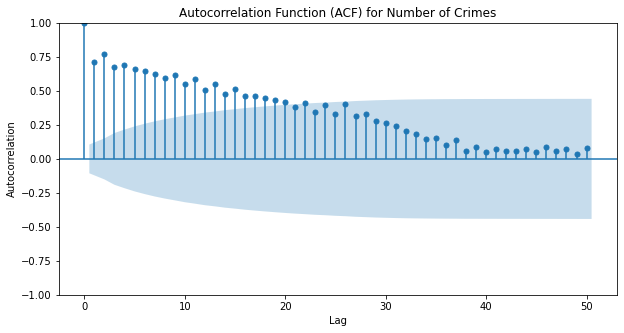

c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


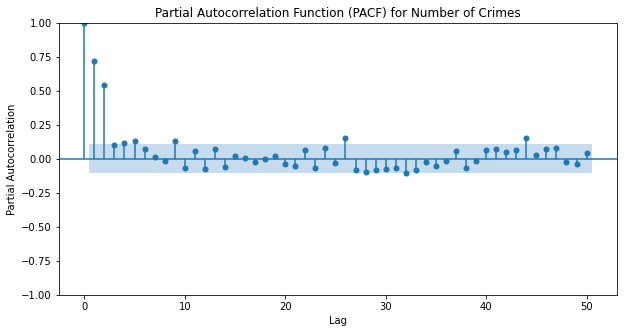

In [19]:
acfPacfPlots(crime_to_forecast)


In [20]:
arima_models = performTimeSeries(
    crime_to_forecast, "ARIMA", top_80pct_crimes, 0.2)


**************************************************
Theft


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Theft
MAPE: 
12.282844035372204
RMSE: 
220.16178301991621
**************************************************
Burglary


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Burglary
MAPE: 
14.966952249906432
RMSE: 
175.35300422103225
**************************************************
Vandalism


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Vandalism
MAPE: 
10.144846766278686
RMSE: 
92.52069381648865
**************************************************
Vehicle Theft


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Vehicle Theft
MAPE: 
8.352568310877134
RMSE: 
97.0871717391456
**************************************************
Assault


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Assault
MAPE: 
10.66254729303675
RMSE: 
83.41796734023343
**************************************************
Domestic Violence


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Domestic Violence
MAPE: 
7.4412929659746805
RMSE: 
47.87495755780401
**************************************************
Identity Theft


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Identity Theft
MAPE: 
31.530046588128435
RMSE: 
419.2190656986209
**************************************************
Assault with Weapon


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Assault with Weapon
MAPE: 
10.23802824602416
RMSE: 
73.741061232483
**************************************************
Robbery


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Robbery
MAPE: 
11.967096455261391
RMSE: 
48.57880470285467
**************************************************
Sexual Misconduct


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Average Number of Crimes:
Evaluation for  Sexual Misconduct
MAPE: 
15.585419894719744
RMSE: 
33.213870797641164
**************************************************
Threats
Average Number of Crimes:
Evaluation for  Threats
MAPE: 
11.087741068772894
RMSE: 
25.14078570229633


c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nirun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
sarima_models = performTimeSeries(
    crime_to_forecast, "SARIMA", top_80pct_crimes, 0.2)


**************************************************
Theft
SARIMA Model Performance:
Train Performance
RMSE: 123.67030560869948
MAPE: 4.560754523763089
Test Performance:
RMSE: 202.53956892665116
MAPE: 11.207701981508619
Average Number of Crimes:
**************************************************
Burglary
SARIMA Model Performance:
Train Performance
RMSE: 136.40865563507182
MAPE: 6.1102836259682025
Test Performance:
RMSE: 166.59519463627606
MAPE: 14.05390134886165
Average Number of Crimes:
**************************************************
Vandalism
SARIMA Model Performance:
Train Performance
RMSE: 78.50423478772122
MAPE: 5.689521394765444
Test Performance:
RMSE: 94.7169204287283
MAPE: 10.52616876947831
Average Number of Crimes:
**************************************************
Vehicle Theft
SARIMA Model Performance:
Train Performance
RMSE: 69.06583312949671
MAPE: 6.371549246786308
Test Performance:
RMSE: 115.95096441290598
MAPE: 10.101212051161173
Average Number of Crimes:
**************

### Regression

In [18]:
crime_to_regress = prepDataModel(crime_df, "Regression", top_80pct_crimes)


In [19]:
# set test data size, number of k-folds, and parameter grid
test_size = 0.2
n_folds = 5
param_grid = {
    'RandomForest': {'n_estimators': [500], 'max_depth': [10]}}


In [20]:
model = build_final_model(crime_to_regress, 'Number of Crimes',
                          test_size, n_folds, param_grid, models=['RandomForest'])


In [22]:
with open('Crime Forecasting Model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [18]:
with open('Crime Forecasting Model.pkl', 'rb') as f:
    model = pickle.load(f)


In [25]:
mape_train, mape_test, mse_train, mse_test = evaluate_model(
    model, crime_to_regress, 'Number of Crimes', 0.2)

Train MAPE: 0.69%
Test MAPE: 0.69%
Train MSE: 16.06
Test MSE: 15.98


In [ ]:
area_crime_preds, crime_preds = getForecasts(crime_df, 14, "DR_NO", top_80pct_crimes, crime_by_area_df, model, op_path)